In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

*Hello B2Metric Team! Here is my project notebook which contains the following sections: Preprocessing, Model Validation, Baseline Models, Feature Selection using LOFO, Hyperparamter Optimization, Performance Improvement, and Comments of Model Variables. I have aimed to always explain the reasoning behind the decisions I make. If anything is unclear, please let me know. Also, as I am still a beginner in the field, I would love to hear your insights, if possible, about how you would have tackled the challenge. Now, without further ado, let's get straight to work*

# Introductory Notes: 

In the preprocessing phase, I have taken a look at what other kagglers have done and used their steps. However, instead of directly importing their preprocessed datasets through pickle or joblib, I have decided to reproduce them myself along with some exploratory data analysis because I believe that it was important for me to spend some time with the dataset and get familiar with it. Nevertheless, I did not perform an important step in preprocessing: balancing the dataset. This resulted in low model performance as I will discuss later on. 

In the hyperparameter optimization step, I have attempted RandomizedSearch, GridSearch, and Optuna. The first two techniques took very long to run, hence, I did not get the opportunity to benefit from their results. Optuna, on the hand, ran faster and I used its results in the subsequent steps of the notebook. 

Throughout the notebook, there are some cells that take very long to run (model validation using RepeatedKFold, get LOFO importance, optuna otimization, etc.) Some of them take about 11 mins (RepeatedKFold), some take 6 hours (LOFO). I have thus commented them out. If you would like to see the output dynamically, please go ahead and run them :)! 

# 1. Preprocessing: 

Let's first start by installing and importing all the necessary dependencies! 

Installing lofo-importance for feature selection.

In [ ]:
!pip install lofo-importance

Installing Optuna for hyperparameter tuning/optimization: 

In [ ]:
!pip install optuna

Making all necessary imports. 

In [ ]:
import pandas as pd
import numpy as np
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from lofo import LOFOImportance, plot_importance, Dataset
import lightgbm as lgbm
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import optuna

Let's read the input csv files into pandas dataframes for data preprocessing. I am also making a copy of the train dataframe as I would like to keep an untouched version of the data for visualizations later on in the notebook. 

In [ ]:
train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
print('Train set shape: ', train.shape)
print('Test set shape: ', test.shape)

In [ ]:
original_train = train.copy(deep  = True)

One of the many factors that might impact a model's performance is the existence of missing values. If there aren't that many missing values, they could safely be dropped. However, if there are a whole lot, dropping them would lead to significant information loss. In this case they ought to be imputed. 

Let's inspect our dataset and see how many missing entries it has. This will be done by computing the percentage of missing values in each column. 

In [ ]:
def missing_values(df):
        
        missing_values = df.isnull().sum()
        #compute the percentage
        missing_values_percent = 100 * df.isnull().sum() / len(df)
        
        # concatenate the two table
        missing_values_table = pd.concat([missing_values, missing_values_percent], axis=1)
        #give the columns more meaningful names
        mis_val_table_ren_columns = missing_values_table.rename(
        columns = {0 : 'Number of Missing Values', 1 : 'Percentage of Entries Missing'})
        # Sort the table in descending order to see biggest values first
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0
                                                             ].sort_values('Percentage of Entries Missing', ascending=False).round(1)
        
        # Return the created missing values dataframe
        return mis_val_table_ren_columns

In [ ]:
missing_values(train)

Wow! As shown above the percentage of missing values could reach values like 69.9%. That's a whole lot. Later on this notebook these values will be imputed using sklearn's SimpleImputer. Now, let's continue exploring our data. 

Let's get more acquainted to our dataset by inspecting the datatypes of its columns. Most machine learning models perform best with numeric values. Let's see how many numeric (and non-numeric) values we have in our dataset. 

In [ ]:
train_dtypes = pd.DataFrame(train.dtypes.value_counts()).reset_index()
train_dtypes.columns = ['dtypes', 'column count']

train_dtypes

It turns out that most columns are numeric (either float64 or int64). This is in fact good news, because it means that we only have to encode 16 categorical features. 

Let's take a closer look at the categoricals. The most important thing here is that we know whether they are binary of multiclass, because this will impact how we encode them. 

In [ ]:
train.loc[:, train.dtypes == np.object].describe()

The unique row tells us the number of unique values in each column. It turns out that we have both binary and multiclass categorical features. The binary ones will be label encoded, i.e. they will be given 0 for val1 and 1 for val2, multiclass features will be one-hot encoded, i.e. we will create a new column for each value with each one of these columns being label encoded. Let's start. 

Label encoding binary columns: 

In [ ]:
# Instantiate a label encoder
label_encode = LabelEncoder()
# Iterate over columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            label_encode.fit(train[col])
            # apply the transformation to both train and test sets
            train[col] = label_encode.transform(train[col])
            test[col] = label_encode.transform(test[col])

One-hot encoding multiclass columns: 

In [ ]:
#one-hot encode the multiclass categoricals
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)
train_labels = train['TARGET']

#align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

#add the target back in
train['TARGET'] = train_labels
print('Aligned Training Features shape: ', train.shape)
print('Aligned Testing Features shape: ', test.shape)

Now, I will start doing some exploratory data analysis. This process has many advantages. It allows us to better understand the dataset, which will certainly lead us to building a better model. Also, it could be useful if we want to later detect outliers and skewed data. 

First thing I will visualize is the target variable. In applications that involve default/fraud detection, the dataset tends to be unbalanced. Let's see if that's the case for us. 

In [ ]:
train['TARGET'].value_counts()
train['TARGET'].value_counts().plot(kind='bar', figsize=(10,5), color = ['blue', 'red'])
plt.xlabel('Target Value')
plt.ylabel('Number of occurances') 
plt.show()

It turns out that our dataset is in fact very much unbalanced. This poses a problem for many machine learning problems. In a more detailed project, I would certainly look into this. But for the sake of completing the tasks now, this will be skipped. 

Now, I will take care of numeric features. For this, I will use a function that plots the KDE (Kernel Density Estimation) of each feature against the target. This will allow us to see how the distribution of the target is influenced by the said feature, and would hence give us insights about the most important features to take into consideration. 

In [ ]:
#Defining a function to plot KDE plots

def plot_kde(df, col, reverse_scale = False):
    
    plt.figure(figsize = (12, 6))
    
    if reverse_scale == True:
        r = -1
    else:
        r = 1
    
    #KDE of paid loans (target == 0)
    sns.kdeplot(df.loc[df['TARGET'] == 0, col] * r, label = 'Target: 0', color = 'green', shade = True)

    #KDE of defaults (target == 1)
    sns.kdeplot(df.loc[df['TARGET'] == 1, col] * r, label = 'Target: 1', color = 'purple', shade = True)

    plt.xlabel('{}'.format(col)); plt.ylabel('KDE'); plt.title('KDE for column {}'.format(col));
    plt.show()
    plt.close()



With the function defined above, we should just call it on different columns to generate the plots. 

In [ ]:
# iterate over all float (continuous) variables and plot KDE
for col in original_train.loc[:, (original_train.dtypes == np.float64)].columns.values:
    # do not plot target 
    if col != 'TARGET':
        # reverse axis if values are negative
        if (original_train[col].median() < 0):
            plot_kde(train,col, reverse_scale = True)
        else:
            plot_kde(train,col)

After inspecting the plots, a few features catch my attention: 

First, the target is very much influenced by EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, as the two distributions are drastically different.
Second, the changes are less apparent in some other features (DAYS_LAST_PHONE_CHANGE for example)
Third, the target does not seem to be impacted by some features at all (LAND_AREA_MEDI for example). 

Keeping this is mind, let's move on to inspect the categorical features. This time, we will use bar charts.

In [ ]:
# Defining function for plotting categorical bar charts for remaining variables
def plot_bars(df, col):
    
    plt.figure(figsize = (11, 5))
    
    df_high = df[df['TARGET'] == 1].groupby(col)['TARGET'].agg('count')
    df_var = df.groupby(col)['TARGET'].agg('count')
    categorical = df_high.divide(df_var, fill_value = 0) * 100

    # Convert back to df
    df_categorical = categorical.to_frame().reset_index().sort_values('TARGET', ascending = True)

    # Create plot in Plotly for interactive visualisation (with some Starling colours)
    ax = df_categorical.plot(x = col, y = 'TARGET', kind = 'barh', figsize=(10,10), color = 'purple')
    ax.set_xlabel('Percentage of defaulters %')
    ax.set_ylabel(col)
    plt.title('Percentage of defaulters plot for {}'.format(col.lower()));
    plt.show()
    plt.close()

In [ ]:
# iterate over object/categorical columns and plot
for col in original_train.loc[:, original_train.dtypes == np.object].columns.values:
    plot_bars(original_train, col)

As shown on the bar plots above, some features, such as NAME_INCOME_TYPE, seem to closely influence that target, whereas this is less pronounced or not at all in other features

A great tool (albeit not always sufficient) to understand relationships between features and target is by using correlations. This can make it easier to spot how a feature affects the target than using plots (although plots often have valuable visual cues). 

In [ ]:
# Find correlations with the target(takes a while due to many features)
correlations = train.corr()['TARGET'].sort_values()

Our features of interest are of course the ones that have the most positive correlations with the target and those with the most negative correlations. Let's find out what they are. 

In [ ]:
print('Most Positive Correlations:\n')
print(correlations.sort_values(ascending = False).head(16))
print('\nMost Negative Correlations:\n')
print(correlations.head(15))

I will make a list of these features because these are the ones I will use to fit my baseline models. There are two reasons behind this decision: first, they are likely to produce better baselines based on which I can make improvements, and second, this can greatly reduce the computational demands (I have tried fitting my model and running LOFO using all features and it was indeed very time-consuming and computationally expensive)

In [ ]:
ft_list = list(correlations.index)[0:15] + list(correlations.index)[-16:]
ft_list

Let's make a new sub-dataframe that would contain these features only

In [ ]:
df = train[ft_list]
df

I am keeping a copy of this dataframe because I will need it later on in LOFO.

In [ ]:
sample = df.copy(deep = True)

Let's create two new datasets, X_train and y_train, which will be used to later on fit our models, in additin to X_test, used for final predictions

In [ ]:
# create X_train, y_train
X_train = df.drop('TARGET', axis = 1)
y_train = df['TARGET']
X_test = test[ft_list[:len(ft_list)-1:]]
target = y_train
features = X_train
# Feature names
features_list = list(X_train.columns)

As a final preprocessing step, we will impute our data and scale it. For Imputing, I used the median strategy, i.e., missing values will be replaced by the median of their respective column. MinMax Scaling is also important to make sure that higher values are not necessarily given greater importance. 

In [ ]:
#Impute missing values using median strategy
imputer = SimpleImputer(strategy = 'median')

#Scale all values in 0-1 range
scaler = MinMaxScaler(feature_range = (0, 1))

#fit the imputer on training set
imputer.fit(X_train)

#transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

#fit scaler and transform
scaler.fit(X_train)
train = scaler.transform(X_train)
test = scaler.transform(X_test)


This concludes our preprocessing. Of course, it could have been more thorough and involved more steps, but for now, and for lack of time, we will proceed to the next steps. 

# 2. Model Validation: 

For model validation, I had the choice between various techniques (KFold, StratifiedKFold, RepeatedKFold, etc.). I have decided to use repeated KFold, and that is for the following reason: A single run of KFold may result in a noisy estimate of the model's performance. Hence, we could get a better and more reliable estimate by repeating the procedure multiple times. 

The easiest way to use cross validation using sklearn's API is via cross_val_score, so that's what I used. 

Here I am instantiating two ML models: LightGBM and Sklean Ridge. Since this is a classification problem, I am using the respective classifier of each model. I haven't yet done any hyperparameter tuning, so I will just use simple or default parameters for now. 

In [ ]:

lgbm_model = lgbm.LGBMClassifier(n_estimators=500, objective = 'binary', 
                                learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 42)
ridge_model = RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=True, random_state=None, solver='auto',
                tol=0.001)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

These following cells are used to get the score of each model. I have them commented out now because I already ran them once and decided not to redo it since it took about 11mins to run. If you'd like to run it, just uncomment. 

In [ ]:
#scoring the lgbm model
#scores = cross_val_score(lgbm_model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
#print('Mean F1: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
#scoring the ridge model
#scores = cross_val_score(ridge_model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
#print('Mean F1: %.3f (%.3f)' % (mean(scores), std(scores)))

According to the F1 score, the two models seem quite equivalent. 

# 3. Baseline Models with simple parameters: 

Now, it's time to build our baseline models! 

Let's first split the data on train and test. This is done sklearn's train_test_split. 

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)


Let's first fit our LGBM model previously defined. This cell might take a while to run. 

In [ ]:
lgbm_model.fit(train_features, train_labels)

We'll do the same for the ridge classifier

In [ ]:
ridge_model.fit(train_features, train_labels)

Let's make initial predictions from our two models

In [ ]:

lgbm_predictions = lgbm_model.predict(test_features)
ridge_predictions = ridge_model.predict(test_features)


Now let's make the initial model evaluation for our two models. Since we are dealing with a classification problem, I have chosen to take into consideration the most used classification metrics: Accuracy, Precision, Recall, and F1 score. 

In [ ]:
#let's get the scores
def get_scores (preds): 
    print('Accuracy: %.3f' % accuracy_score(test_labels.values, preds))
    print('Precision: %.3f' % precision_score(test_labels.values, preds))
    print('Recall: %.3f' % recall_score(test_labels.values, preds))
    print('F1: %.3f' % f1_score(test_labels.values, preds))
print('LGBM scores: ')
get_scores(lgbm_predictions)
print('Ridge scores: ')
get_scores(ridge_predictions)

Those are some quite interesting results. Although the accuracy is quite high (92%), the precision, recall and F1 scores are incredibly low. This reminds us of the fact that accuracy is not always the right metric to use. My assumption here is that the model is almost always predicting that the client will not default (which is usually the case), making it an extremely naive model. This might be due to the fact that our dataset is not balanced: most entries in the target are 0s. This could have been addressed in the beginning by attempting to balance the dataset (using undersampling for example). However, at this point we could fix this, at least in the LGBM model, which seems to be the most promising one, by using is_unbalanced or scale_pos_weight in the class_weight parameter. 

Let's not get upset about the low values of the metrics, we're here to improve them after all! The first thing I would like to do is take a look at the feature importance, this shows the features that the model relied on the most, and could give us some insights about what features were useful and what weren't. 

I have written down a function to extract feature importances. However, I later discovered that RidgeClassifier does not support feature importances in its API. Hence, we will inspect this for LightGBM only. Later on, I will use LOFO, which is model agnostic and will work on both of them. 

In [ ]:
#out of curiosity, let's take a look at our feature performance
def extract_feature_importance(model): 
    model_fi = model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': features_list, 'Importance': model_fi})
    return feature_importances
lgbm_fi = extract_feature_importance(lgbm_model)


Let's plot the feature importance now to visually inspect it. 

In [ ]:
def plot_feature_importance(df):

    # Normalize the feature importances to add up to one
    df['Importance_normalized'] = df['Importance'] / df['Importance'].sum()
    df = df.sort_values('Importance_normalized', ascending = True).tail(20)

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 16))

    ax = df.plot(x = 'Feature' , y = 'Importance_normalized', kind = 'barh', figsize=(10,10), color = 'blue')
    
    # Plot labeling
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.show()
    
    # return top 20 features
    return(df['Feature'])


In [ ]:
lgbm_top = plot_feature_importance(lgbm_fi)

It turns out that the model is only making significant use of a handful to features, namely EXT_SOURCE_2, DAYS_REGISTRATION, DAYS_ID_PUBLISH, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH, EXT_SOURCE_3, DAYS_EMPLOYED, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE

However, just because the model is relying on them the most doesn't mean that they are necessary or that they improve its performance. In order to find out which features are the best, we will use LOFO (Leave One Feature Out). 

# 4. Feature Selection with LOFO importance: 

What LOFO does is basically what its name says: it takes out one features at a time, and sees how the model performs without it (better or worse). We can then plot the importances in order to see which features are good and which ones are harmful. This step is essential because it's just enough to feed to model some features: we need to feed it the right ones. Because, as the famous data science saying goes: garbage in, garbage out. If we don't take the time to select our features carefully, we will not get good results. 

In [ ]:
# define the binary target and the features
dataset = Dataset(df=sample, target="TARGET",features = features)

In [ ]:
# define the validation scheme and scorer. 
lofo_imp = LOFOImportance(dataset, model = lgbm_model, scoring="accuracy")

The cell below took a very long time to run. Just for 30 features, it took 6 full hours! And that's just for one model (LightGBM). I think that this is drawback of LOFO. Eventhough it gives great insights and is model agnostic, it simply is too slow. That's something that might dissuade a lot of data scientists from using it. 

I have commented out the LOFO-importance cells because they took too long to run. If you have more powerful hardware and computational resources, please go ahead and run them. 

In [ ]:
# get the mean and standard deviation of the importances in pandas format
#importance_df = lofo_imp.get_importance()

In [ ]:
# plot the means and standard deviations of the importances
#plot_importance(importance_df, figsize=(12, 20))

Upon running the cell above, I obtained the following plot: 
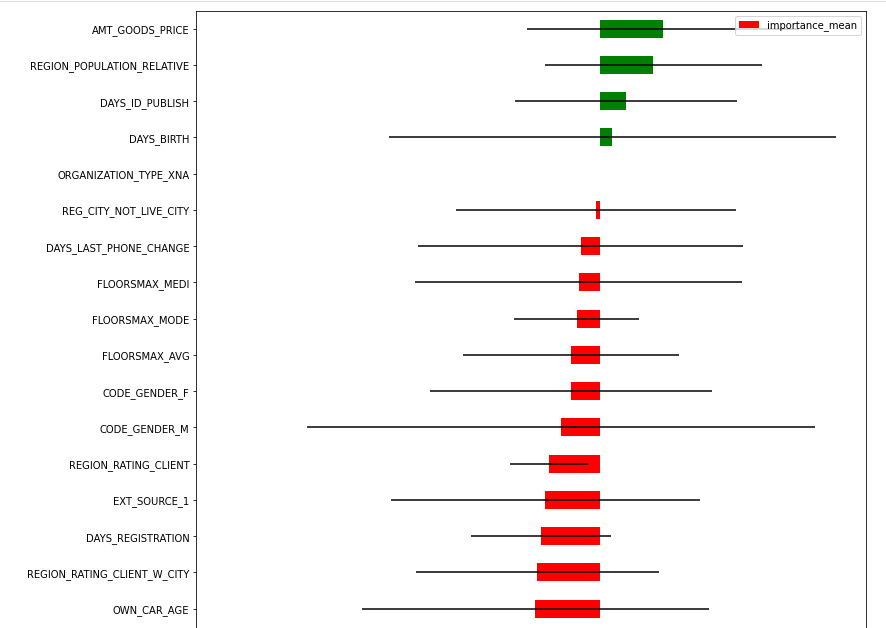

After six hours of running, we could finally obtain the LOFO importance plot. It shows that only 4 features had a positive score: **AMT_GOOD_PRICE, REGION_POPULATION_RELATIVE, DAYS_ID_PUBLISH, DAYS_BIRTH.** All other features actually did more harm than good. So, these are the features that we'll keep for the LightGBM model. 

If we compare these to the results obtained via feature importance we could say that they are somewhat similar. The four features mentioned are also among the top 10 according to feature importance, but of course, LOFO gives us further insights because it tells us which ones are also harming the model.  

In [ ]:
#lofo_imp_ridge = LOFOImportance(dataset, model = ridge_model, scoring="accuracy")

In [ ]:
#ridge_importance_df = lofo_imp_ridge.get_importance()

In [ ]:
#plot_importance(ridge_importance_df, figsize=(12, 20))

# 5. Hyperparameter Optimization: 

Now I will start the hyperparameter optimization. This is an essential step to get better performance because the quality of our model necessarily depends on the parameters it was instantiated with. 

There are many tools for hyperparameter optimization. The most famous ones are RandomizedSearch and GridSearch (which I have attempted below). BayesianSearch has also been gaining attention lately because it produces good results in a shorter amount of time. Another new tool in Optuna, which I have also attempted. 

I begin by defining a cross validation scheme. Again, I use RepeatedKFold. 

In [ ]:
 #define the CV instance that will be used for hyperparameter optimization
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 42)


Now, I will define the search space of my LGBM model. I have decided to tune 5 parameters only. However, I could definitely do more, especially if I had more powerful computational capabilities. 

In [ ]:
#define LGBM search space
lgbm_space = dict()
lgbm_space['num_leaves'] = [50,100,1000]
lgbm_space['max_depth'] = [5,30,50]
lgbm_space['min_data_in_leaf'] = [200,5000,10000]
lgbm_space['learning_rate'] = [0.01,0.1, 0.5]
lgbm_space['n_estimators'] = [100, 500, 1000]

I do the same for the ridge model. 

In [ ]:
#define ridge search space
ridge_space = dict()
ridge_space['alpha'] = [0.1, 0.5, 1]
ridge_space['solver'] = ['auto', 'svd', 'sag', 'saga', 'lbfgs']
ridge_space['random_state'] = [42]

In [ ]:
#define base models
lgbm_base = lgbm.LGBMClassifier()
ridge_base = RidgeClassifier()

Now I define two instances of RandomizedSearchCV. I am limiting the number of iterations to 10 in order to make the fitting faster. I am using F1 score because it is a good middle ground between precision and recall. 

In [ ]:
lgbm_rand_search = RandomizedSearchCV(lgbm_base, lgbm_space, n_iter = 5, scoring = 'f1', n_jobs = -1)

In [ ]:
ridge_rand_search = RandomizedSearchCV(ridge_base, ridge_space, n_iter = 5, scoring = 'f1', n_jobs = -1)

I have this cell commented out because it takes too long to run. This is problem that I have faced repeatedly in this challenge. 

In [ ]:
#lgbm_rand_result = lgbm_rand_search.fit(train_features, train_labels)

In [ ]:
#ridge_rand_result = ridge_rand_search.fit(train_features, train_labels)

In [ ]:
#print('LGBM RS Best Score: %s' % lgbm_rand_result.best_score_)
#print('LGBM RS Best Hyperparameters: %s' % lgbm_rand_result.best_params_)

In [ ]:
#print('Ridge RS Best Score: %s' % ridge_rand_result.best_score_)
#print('Ridge RS Best Hyperparameters: %s' % ridge_rand_result.best_params_)

After facing very slow running for RandomizedSearch, I have moved to GridSearch, because randomized is known to be way slower. 

In [ ]:
lgbm_grid_search = GridSearchCV(lgbm_base, lgbm_space, scoring = 'f1', n_jobs = -1)

In [ ]:
ridge_grid_search = GridSearchCV(ridge_base, ridge_space, scoring = 'f1', n_jobs = -1)

Yet, I have faced the same problem here. The cell ran for well more than an hour when I decided to stop running and use Optuna. Of course, one hour of running is not too much in the machine learning (some deep learning models take days to train), but I unfortunately do not have the luxury of time here. 

In [ ]:
#lgbm_grid_result = lgbm_grid_search.fit(train_features, train_labels)

In [ ]:
#ridge_grid_result = ridge_grid_search.fit(train_features, train_labels)

In [ ]:
#print('LGBM GS Best Score: %s' % lgbm_grid_result.best_score_)
#print('LGBM GS Best Hyperparameters: %s' % lgbm_grid_result.best_params_)

In [ ]:
#print('Ridge GS Best Score: %s' % ridge_grid_result.best_score_)
#print('Ridge GS Best Hyperparameters: %s' % ridge_grid_result.best_params_)

Now I will go ahead and use Optuna. Optuna is a new tool for hyperparameter optimization that has become in style lately because of the various advantages it offers, such as not requiring the user to specify a static search space, its use of pruning (i.e. cutting an unpromising trial based on intermediate results), and it also gives the user more control over the model in general.  

This is my first time using Optuna and I am really glad I got the chance to learn how to use it. I first start by defining the objective function. 

In [ ]:

def objective_lgbm (trial): 
    print("Started Trial...")
    #the hyperparameters to tune
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 500]),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 100, 3000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 1000, step=100),
        "random_state": 42,
        "n_jobs":-1
    }
    lgbm_optuna_model = lgbm.LGBMClassifier(objective = 'binary', **param_grid)
    return cross_val_score(lgbm_optuna_model, train_features, train_labels, scoring = 'f1', cv=cv,n_jobs = -1).mean()


Next, I define an Optuna Study. This takes one parameter, which is direction. I set it to 'maximize' because my scoring metric is F1 score, and this metric is maximized for better results. 

In [ ]:
lgbm_study = optuna.create_study(direction = 'maximize')


Now, I am optimizing the hyperparameters. Indeed, this cell took some time to run, but it was generally faster than GridSearch and RandomSearch. Also, the intermediate outputs were printed which made it easier to keep up with the progress. Please not that I have used only 20 trials. Optuna is usually run with a far larger number, but again, I did this for the sake of efficiency. 

In [ ]:
#lgbm_study.optimize(objective_lgbm, n_trials = 20)

The optimization process ran for about an hour and 40 mins. Let's see what Optuna came up with. 

In [ ]:
#best_lgbm_optuna = lgbm_study.best_trial
#print('LGBM F1: {}'.format(best_lgbm_optuna.value))

It turns out the best trial was trial 18, which resulted in an F1 score equal to 0.04969739265934099

Let's see what the best parameters are: 

In [ ]:
#print("Best LGBM hyperparameters: {}".format(best_lgbm_optuna.params))

The best parameters for LGBM using optuna are the following: **{'n_estimators': 500, 'learning_rate': 0.09913706634323802, 'num_leaves': 900, 'max_depth': 8, 'min_data_in_leaf': 600}**

I redo the same process for the ridge classifier.

In [ ]:
def objective_ridge (trial): 
    #the hyperparameters to tune
    param_grid = {
    'solver' : trial.suggest_categorical("solver", ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']), 
    'alpha' : trial.suggest_uniform('alpha', 0.5, 1), 
    "random_state": 42
    }
    ridge_optuna_model = RidgeClassifier(**param_grid)
    return cross_val_score(ridge_optuna_model, train_features, train_labels, scoring = 'f1', cv=cv,n_jobs = -1).mean()

In [ ]:
ridge_study = optuna.create_study(direction = 'maximize')


Let's optimize ridge's paramaters. I am using 10 trials for the sake of running the code in shorter time.  

In [ ]:
#ridge_study.optimize(objective_ridge, n_trials = 10)

Let's see what Optuna came up with for ridge. 

In [ ]:
#best_ridge_optuna = ridge_study.best_trial
#print('F1: {}'.format(best_ridge_optuna.value))

Best parameters for ridge: 

In [ ]:
#print("Best Ridge hyperparameters: {}".format(best_ridge_optuna.params))

Eventually I obtained that the best parameters for ridge are **{'solver': 'auto', 'alpha': 0.9115035913991532}**, however, the performance of the model remains incredibly low. Apparently, the RidgeClassifier would need further studies that are beyond the scope of this notebook. 

# 6. Performance improvement: 

In this section, I will conduct a few experiments and see which ones improve the performance of the model. 

First, I will train the models with the features favored by LOFO. These features were 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_ID_PUBLISH', and 'DAYS_BIRTH'. I create a new dataframe containing these features only and impute it and scale it. 

In [ ]:
reduced_ft_list = ['AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']
reduced_X_train = df[reduced_ft_list]
reduced_X_train

In [ ]:
#impute and scale reduced_X_train
imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))
imputer.fit(reduced_X_train)
reduced_X_train = imputer.transform(reduced_X_train)
scaler.fit(reduced_X_train)
train = scaler.transform(reduced_X_train)

In [ ]:
#train test split new dataset
reduced_train_features, reduced_test_features, reduced_train_labels,reduced_test_labels = train_test_split(reduced_X_train, y_train, test_size = 0.2, random_state = 42) 

Defining two models set with the same parameters as my baseline models in order to make comparisons between the two meaningful (i.e. I am comparing how the feature selection impacts the performance all else equal). 

In [ ]:
reduced_lgbm_model = lgbm.LGBMClassifier(n_estimators=500, objective = 'binary', 
                                learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 42)
reduced_ridge_model = RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=True, random_state=None, solver='auto',
                tol=0.001)

In [ ]:
reduced_lgbm_model.fit(reduced_train_features,reduced_train_labels)

In [ ]:
reduced_ridge_model.fit(reduced_train_features,reduced_train_labels)

Making predictions with the new models. 

In [ ]:
reduced_lgbm_predictions = reduced_lgbm_model.predict(reduced_test_features)
reduced_ridge_predictions = reduced_ridge_model.predict(reduced_test_features)

In [ ]:
print('LGBM scores: ')
get_scores(reduced_lgbm_predictions)
print('Ridge scores: ')
get_scores(reduced_ridge_predictions)

Interesting... I would have expected the models' performance to improve but it turns out that it didn't. The accuracy remained almost the same for both models, while the Precision, Recall, and F1 score. Although I followed what I had been told by LOFO, the performance worsened rather than improved. Let's see if hyperparameters can fix this. 

Next, I will train the models with the hyperparameters obtained by Optuna but using the original set of features and see how that goes. From now on, I will focus of LGBM since it is the most promising model. 

In [ ]:
tuned_lgbm_model = lgbm.LGBMClassifier(n_estimators= 500, learning_rate = 0.09913706634323802, 
                                       num_leaves = 900, max_depth = 8, min_data_in_leaf = 600)

In [ ]:
tuned_lgbm_model.fit(train_features, train_labels)

In [ ]:
tuned_lgbm_predictions = tuned_lgbm_model.predict(test_features)

In [ ]:
print('Tuned LGBM scores: ')
get_scores(tuned_lgbm_predictions)

Last, I will train the models using the LOFO selected features and the hyperparameters obtained by Optuna. 

In [ ]:
reduced_tuned_lgbm_model = lgbm.LGBMClassifier(n_estimators= 500, learning_rate = 0.09913706634323802, 
                                       num_leaves = 900, max_depth = 8, min_data_in_leaf = 600)

In [ ]:
reduced_tuned_lgbm_model.fit(reduced_train_features, reduced_train_labels)

In [ ]:
reduced_tuned_lgbm_predictions = reduced_tuned_lgbm_model.predict(reduced_test_features)

In [ ]:
print('Tuned LGBM scores: ')
get_scores(reduced_tuned_lgbm_predictions)

Although all the models produced so far perform rather poorly, the best one so far is tuned_lgbm_model (i.e. the model in which I used Optuna's optimized hyperparameters and the initial features, not the ones selected by LOFO). This goes to show that LOFO did not really enhance the performance. Of course, this does not mean that it is not useful, but it didn't work in our favor in this context. On the other hand, hyperparameter optimization did serve us some good! 

# 7. Comments on model variables: 

In this final section, I will comment of the results of the best performing model so far: tuned_lgbm_model. 

In [ ]:
classification_report(test_labels, tuned_lgbm_predictions, output_dict = True)

Let's interpret the classification report generated above. It shows that for the first label/class, the metrics seem quite good. Which means the model was able to predict non-defaults very well. On the other hand, the metrics of the second label are very much low, which means the model failed to predict defaulters. This is a common result in machine learning when the dataset is unbalanced. 

Let's generate the classification report and confusion matrix. 

In [ ]:
confusion_matrix(test_labels, tuned_lgbm_predictions)

The confusion matrix is used to showcase the number of True Positive (correctly predicted as defauters), True Negative (correctly predicted as non-defaulters), False Positive (incorrectly predicted as defaulters), False Negative (incorrectly predicted as non-defaulters). 

In our case: TN = 56407, TP = 131, FP = 147 , FN = 4818

This goes on to confirm the fact that the model fails at predicting positives (defaulters.)

# Closing Notes: 

Of course, the final ML model I have reached is far from being perfect. In my work, I have focused on completing the taks rather than on producing the best model. Moreover, I was often limited my the computational complexity of the tasks, especially since I was using a Kaggle CPU and not a GPU or TPU (they wouldn't have enhanced the results since they are mostly useful for neural networks). However, in order to improve my results, I would: 
1. Balance the Dataset in the preprocessing step
2. Tune more parameters and carefully create the search spaces
3. Do some feature engineering
4. Make more experimented and record the pros and cons of each
5. Try out other models (RandomForest for e.g.)


# Thank you B2Metric for the project! 